In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

In [3]:
# Load the dataset
file_path = 'training_data.csv'
data = pd.read_csv(file_path)
data['increase_stock_binary'] = data['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)
data = data.drop(["increase_stock"], axis=1)
# Display the first few rows of the dataframe
data

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock_binary
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,0
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,0
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,0
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,0
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,0
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,0
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,0
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,1


In [4]:
X = data.to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y = X[:,-1].astype(np.float32)
X = X[:,:-1].astype(np.float32)
X.shape, y.shape

((1600, 15), (1600,))

## Random Forest Ensemble (single validation)

In [10]:
metric = lambda a, b: (a == b).mean()

def RandomForestEnsemble(x, models):
    predictions = [model.predict_proba(x) for model in models]
    proba1 = np.mean(predictions, axis=0)[:, 1] # probability of predicting label 1
    return proba1.round() # [0,0,0,1,0,1,0,0,0,...]

def compute_precision(predictions, labels, positive_label=1):
    TP = ((predictions == positive_label) & (labels == positive_label)).sum().item()
    FP = ((predictions == positive_label) & (labels != positive_label)).sum().item()
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def compute_recall(predictions, labels, positive_label=1):
    TP = ((predictions == positive_label) & (labels == positive_label)).sum().item()
    FN = ((predictions != positive_label) & (labels == positive_label)).sum().item()
    return TP / (TP + FN) if (TP + FN) > 0 else 0

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0, shuffle=True)

seeds = range(50)
scores = []
models = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for s in seeds:
    # Note how the indices between the validation set and train set are flipped.
    # This means that the classifier will be trained on less than 50% of the data.
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        clf = RandomForestClassifier(
            n_estimators=200, max_depth=100, criterion="entropy",
            random_state=s, n_jobs=-1
        )
        clf.fit(X_train[train_index], y_train[train_index])
        # accuracy = clf.score(X_train[test_index], y_train[test_index])
        accuracy = clf.score(X_test, y_test)
        scores.append(accuracy)
        models.append(clf)

print("average accuracy", np.mean(scores))

X_pred = RandomForestEnsemble(X_test, models)
metric(X_pred, y_test)

average accuracy 0.87543


0.8775

In [9]:
X_pred = np.zeros(len(y_test))
print(metric(X_pred, y_test))
for positive_label in [0, 1]:
    recall = compute_recall(X_pred, y_test, positive_label)
    precision = compute_precision(X_pred, y_test, positive_label)
    print(round(precision, 2), round(recall, 2))

0.81
0.81 1.0
0 0.0


In [49]:
X_pred = RandomForestEnsemble(X_test, models)
print(metric(X_pred, y_test))
for positive_label in [0, 1]:
    recall = compute_recall(X_pred, y_test, positive_label)
    precision = compute_precision(X_pred, y_test, positive_label)
    print(round(precision, 2), round(recall, 2))

0.8775
0.91 0.95
0.72 0.58


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0, shuffle=True)

clf = RandomForestClassifier(
    n_estimators=200, max_depth=100, criterion="entropy", oob_score=True,
    random_state=0, n_jobs=-1
)

clf.fit(X_train, y_train)
# clf.score(X_test, y_test), clf.oob_score_

(0.875, 0.9016666666666666)

## Evaluating Random Forest Ensemble with k-fold cross-validaiton

In [10]:
seeds = range(10)
# kf = StraKFold(5, random_state=0, shuffle=True)

for i, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
    X_, X_test = X[train_index], X[test_index]
    y_, y_test = y[train_index], y[test_index]
    models = []
    
    # This loop creates a list of 3 * seeds classifiers using Bagging,
    # by splitting the training set into 3 sets. 
    for s in seeds:
        # Note how the indices between the validation set and train set are flipped.
        # This means that the classifier will be trained on less than 50% of the data.
        for i, (train_index_, _) in enumerate(KFold(n_splits=3).split(X_)):
            X_train = X_[train_index_]
            y_train = y_[train_index_]
            clf = RandomForestClassifier(
                n_estimators=200, max_depth=100, criterion="entropy",
                random_state=s, n_jobs=-1
            )
            clf.fit(X_train, y_train)
            models.append(clf)

    X_pred = RandomForestEnsemble(X_test, models)
    print("ensemble accuracy", metric(X_pred, y_test))

1it [00:13, 13.22s/it]

ensemble accuracy 0.8458333333333333


2it [00:27, 13.86s/it]

ensemble accuracy 0.8958333333333334


3it [00:42, 14.20s/it]

ensemble accuracy 0.8791666666666667


4it [00:56, 14.34s/it]

ensemble accuracy 0.9166666666666666


5it [01:15, 15.20s/it]

ensemble accuracy 0.8958333333333334


In [74]:
np.mean([0.865625, 0.878125, 0.909375, 0.909375, 0.915625])

0.8956250000000001

(array([3., 6., 1., 0., 0., 0., 1., 6., 6., 7.]),
 array([0.84895833, 0.853125  , 0.85729167, 0.86145833, 0.865625  ,
        0.86979167, 0.87395833, 0.878125  , 0.88229167, 0.88645833,
        0.890625  ]),
 <BarContainer object of 10 artists>)

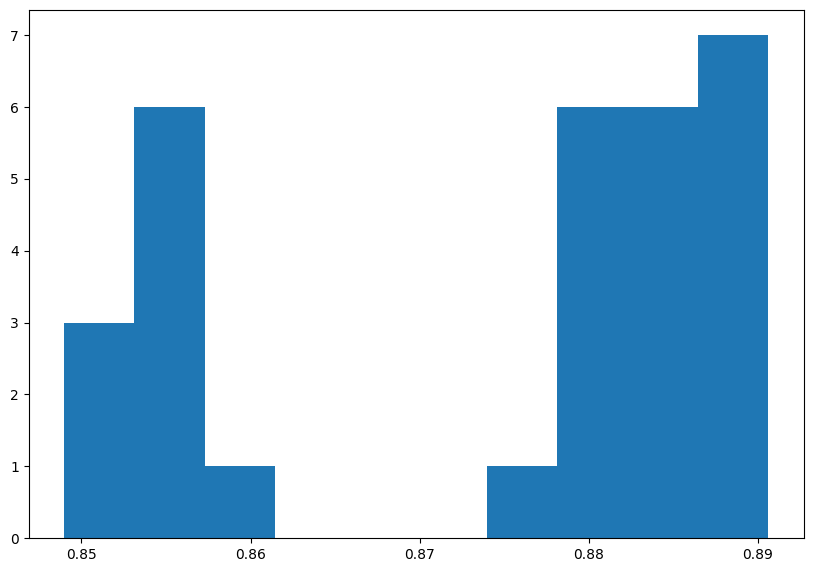

In [152]:
plt.hist(scores)